# Modules, colors, and functions

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
from scipy.stats import moment
import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr

import torch
import torch.nn as nn
import torch.nn.functional as F


from skimage.transform import resize
from scipy.ndimage import fourier_shift, gaussian_filter
from sunpy.map import Map
from skimage.feature import register_translation
from skimage.feature import match_template

import sys, os
sys.path.append("../../../")
from source.patch_stitch import get_patch
from source.prep import map_prep


%matplotlib inline

### Load and interface with Google Cloud Storage

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

## Load source MDI magnetogram

In [6]:
mdi_bucket = 'mdi-fits'
mdi_file = 'mdi-data/mdi-prep/2011/4/1/MDI_20110401-013901.fits'

bucket = client.get_bucket(mdi_bucket)
blob = bucket.blob(mdi_file)
file = blob.download_to_filename('/tmp/tmp_mdi.fits')



source_map = map_prep('/tmp/tmp_mdi.fits', instrument='MDI')

x, y = np.meshgrid(*[np.arange(v.value) for v in source_map.dimensions]) * u.pixel
hpc_coords = source_map.pixel_to_world(x, y)
rSun = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / source_map.rsun_obs
source_map.data[rSun>1] = 0

In [7]:
source_map.meta['cdelt1']

2.017092

## Load Target HMI magnetogram

In [8]:
hmi_bucket = 'hmi-fits'
hmi_file = 'hmi-data/hmi-prep/2011/4/1/HMI_20110401-013418.fits'

bucket = client.get_bucket(hmi_bucket)
blob = bucket.blob(hmi_file)
file = blob.download_to_filename('/tmp/tmp_hmi.fits')

HMI_fits = fits.open('/tmp/tmp_hmi.fits', cache=False)
HMI_fits.verify('fix')

target_map = sunpy.map.Map(HMI_fits[1].data, HMI_fits[1].header)
HMI_fits.close()

x, y = np.meshgrid(*[np.arange(v.value) for v in target_map.dimensions]) * u.pixel
hpc_coords = target_map.pixel_to_world(x, y)
rSun = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / target_map.rsun_obs
target_map.data[rSun>1] = 0

In [9]:
target_map.meta['cdelt1']

0.504273

In [10]:
source_map.meta['cdelt1']/target_map.meta['cdelt1']

4.0

## Upsample source and smooth target

In [11]:
scale_factor = target_map.data.shape[0] / source_map.data.shape[0]

source_upsampled = resize(source_map.data, (target_map.data.shape[0], target_map.data.shape[1]))
target_smooth = gaussian_filter(target_map.data, scale_factor)#/1.5)

target_smooth = Map(target_smooth, target_map.meta)

# Defining new meta parameters
new_meta = source_map.meta.copy()
new_meta['crpix1'] = new_meta['crpix1'] - source_map.data.shape[0] / 2 + source_upsampled.shape[0] / 2
new_meta['crpix2'] = new_meta['crpix2'] - source_map.data.shape[1] / 2 + source_upsampled.shape[1] / 2
new_meta['cdelt1'] = new_meta['cdelt1']/scale_factor
new_meta['cdelt2'] = new_meta['cdelt1']/scale_factor

source_upsampled = Map(source_upsampled, new_meta)

In [12]:
new_meta['cdelt1']

0.504273

In [13]:
source_map.meta['cdelt1']

2.017092

## Create patches

In [14]:
buffer = 64

patchscale = [128,128]

target_smooth_patch = get_patch(target_smooth, int(patchscale[0]),
                                instrument=target_map.detector, stride=int(patchscale[1]), position=True)
target_patch = get_patch(target_map, int(patchscale[0]),
                         instrument=target_map.detector, stride=int(patchscale[1]))
source_patch = get_patch(source_map, int(patchscale[0]),
                         instrument=source_map.detector, stride=int(patchscale[1]))
source_upsampled_patch = get_patch(source_upsampled, int(patchscale[0]),
                                   instrument=source_map.detector, stride=int(patchscale[1]))

target_shifted = target_patch[:, 0:2, :, :]*0


In [15]:
# Padded target map
target_map_padded = np.pad(target_map.data, buffer, mode='constant', constant_values=0)

# Fixing header
new_meta = target_map.meta.copy()
new_meta['crpix1'] = new_meta['crpix1'] - target_map.data.shape[0] / 2 + target_map_padded.shape[0] / 2
new_meta['crpix2'] = new_meta['crpix2'] - target_map.data.shape[1] / 2 + target_map_padded.shape[1] / 2

target_map_padded = Map(target_map_padded, new_meta)
target_map_padded_patch = get_patch(target_map_padded, int(patchscale[0])+2*buffer,
                         instrument=target_map_padded.detector, stride=int(patchscale[1]))

# Padded target smoothed map
target_smooth_padded = np.pad(target_smooth.data, buffer, mode='constant', constant_values=0)
target_smooth_padded = Map(target_smooth_padded, new_meta)
target_smooth_padded_patch = get_patch(target_smooth_padded, int(patchscale[0])+2*buffer,
                         instrument=target_map_padded.detector, stride=int(patchscale[1]))



target_map_padded_patch.shape

(1024, 2, 256, 256)

In [16]:
# scale_factor = target_map.data.shape[0] / source_map.data.shape[0]

# # upsample source and smooth target
# source_upsampled = resize(source_map.data, (target_map.data.shape[0], target_map.data.shape[1]))
# target_smooth = gaussian_filter(target_map.data, scale_factor)

# target_smooth = Map(target_smooth, target_map.meta)
# source_upsampled = Map(source_upsampled, source_map.meta)

# # create patches
# target_smooth_patch = get_patch(target_smooth, int(patchscale[0]),
#                                 instrument=target_map.detector, stride=int(patchscale[1]), position=True)
# target_patch = get_patch(target_map, int(patchscale[0]),
#                          instrument=target_map.detector, stride=int(patchscale[1]))
# source_patch = get_patch(source_map, int(patchscale[0]),
#                          instrument=source_map.detector, stride=int(patchscale[1]))
# source_upsampled_patch = get_patch(source_upsampled, int(patchscale[1]) * scale_factor,
#                                    instrument=source_map.detector, stride=int(patchscale[1]) * scale_factor)

In [17]:
source_upsampled_patch.shape

(1024, 2, 128, 128)

In [18]:
np.zeros((1024,2)).shape

(1024, 2)

## Select patch and visualize it

In [62]:
inx = int(np.floor(np.random.rand()*target_patch.shape[0]))
print(inx)
inx = 712
inx = 611
inx = 340
inx = 652
inx = 646
inx = 407
inx = 410
# inx = 786
# Bad offset
# inx = 716

371


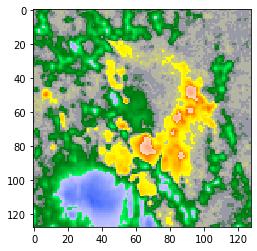

In [63]:
## Target
fig = plt.figure(figsize=(4, 4))
plt.imshow(target_patch[inx,0,:,:], vmin=vmin, vmax=vmax, cmap=current_cmap)

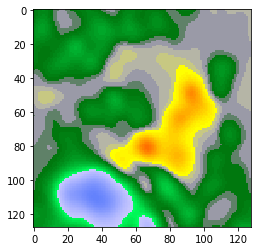

In [64]:
# Smoothed target
fig = plt.figure(figsize=(4, 4))
plt.imshow(target_smooth_patch[inx,0,:,:], vmin=vmin, vmax=vmax, cmap=current_cmap)

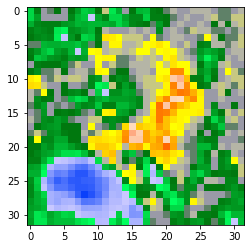

In [65]:
# Source
fig = plt.figure(figsize=(4, 4))
plt.imshow(source_patch[inx,0,:,:], vmin=vmin, vmax=vmax, cmap=current_cmap)

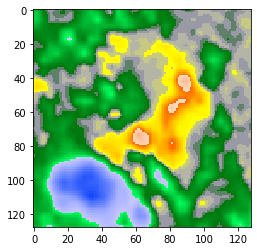

In [66]:
# upsampled Source
fig = plt.figure(figsize=(4, 4))
plt.imshow(source_upsampled_patch[inx, 0, :, :], vmin=vmin, vmax=vmax, cmap=current_cmap)

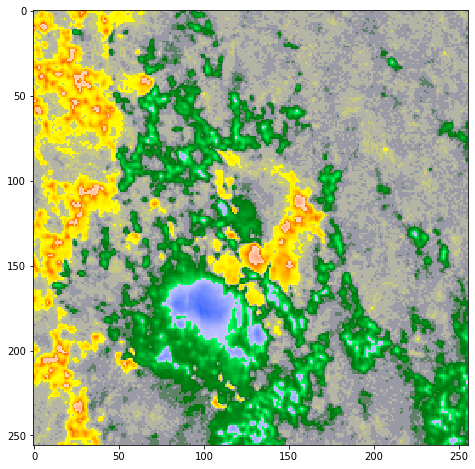

In [67]:
# Larger padded patch from source
scale_plt = (patchscale[0]+2*buffer)/patchscale[0]
fig = plt.figure(figsize=(4*scale_plt, 4*scale_plt))
plt.imshow(target_map_padded_patch[inx, 0, :, :], vmin=vmin, vmax=vmax, cmap=current_cmap)


## Shift vs. template match

In [68]:
def get_shift(source_patch, target_patch):

    shift, _, _ = register_translation(source_patch, target_patch)
    return shift

4.0 5.0
4 6


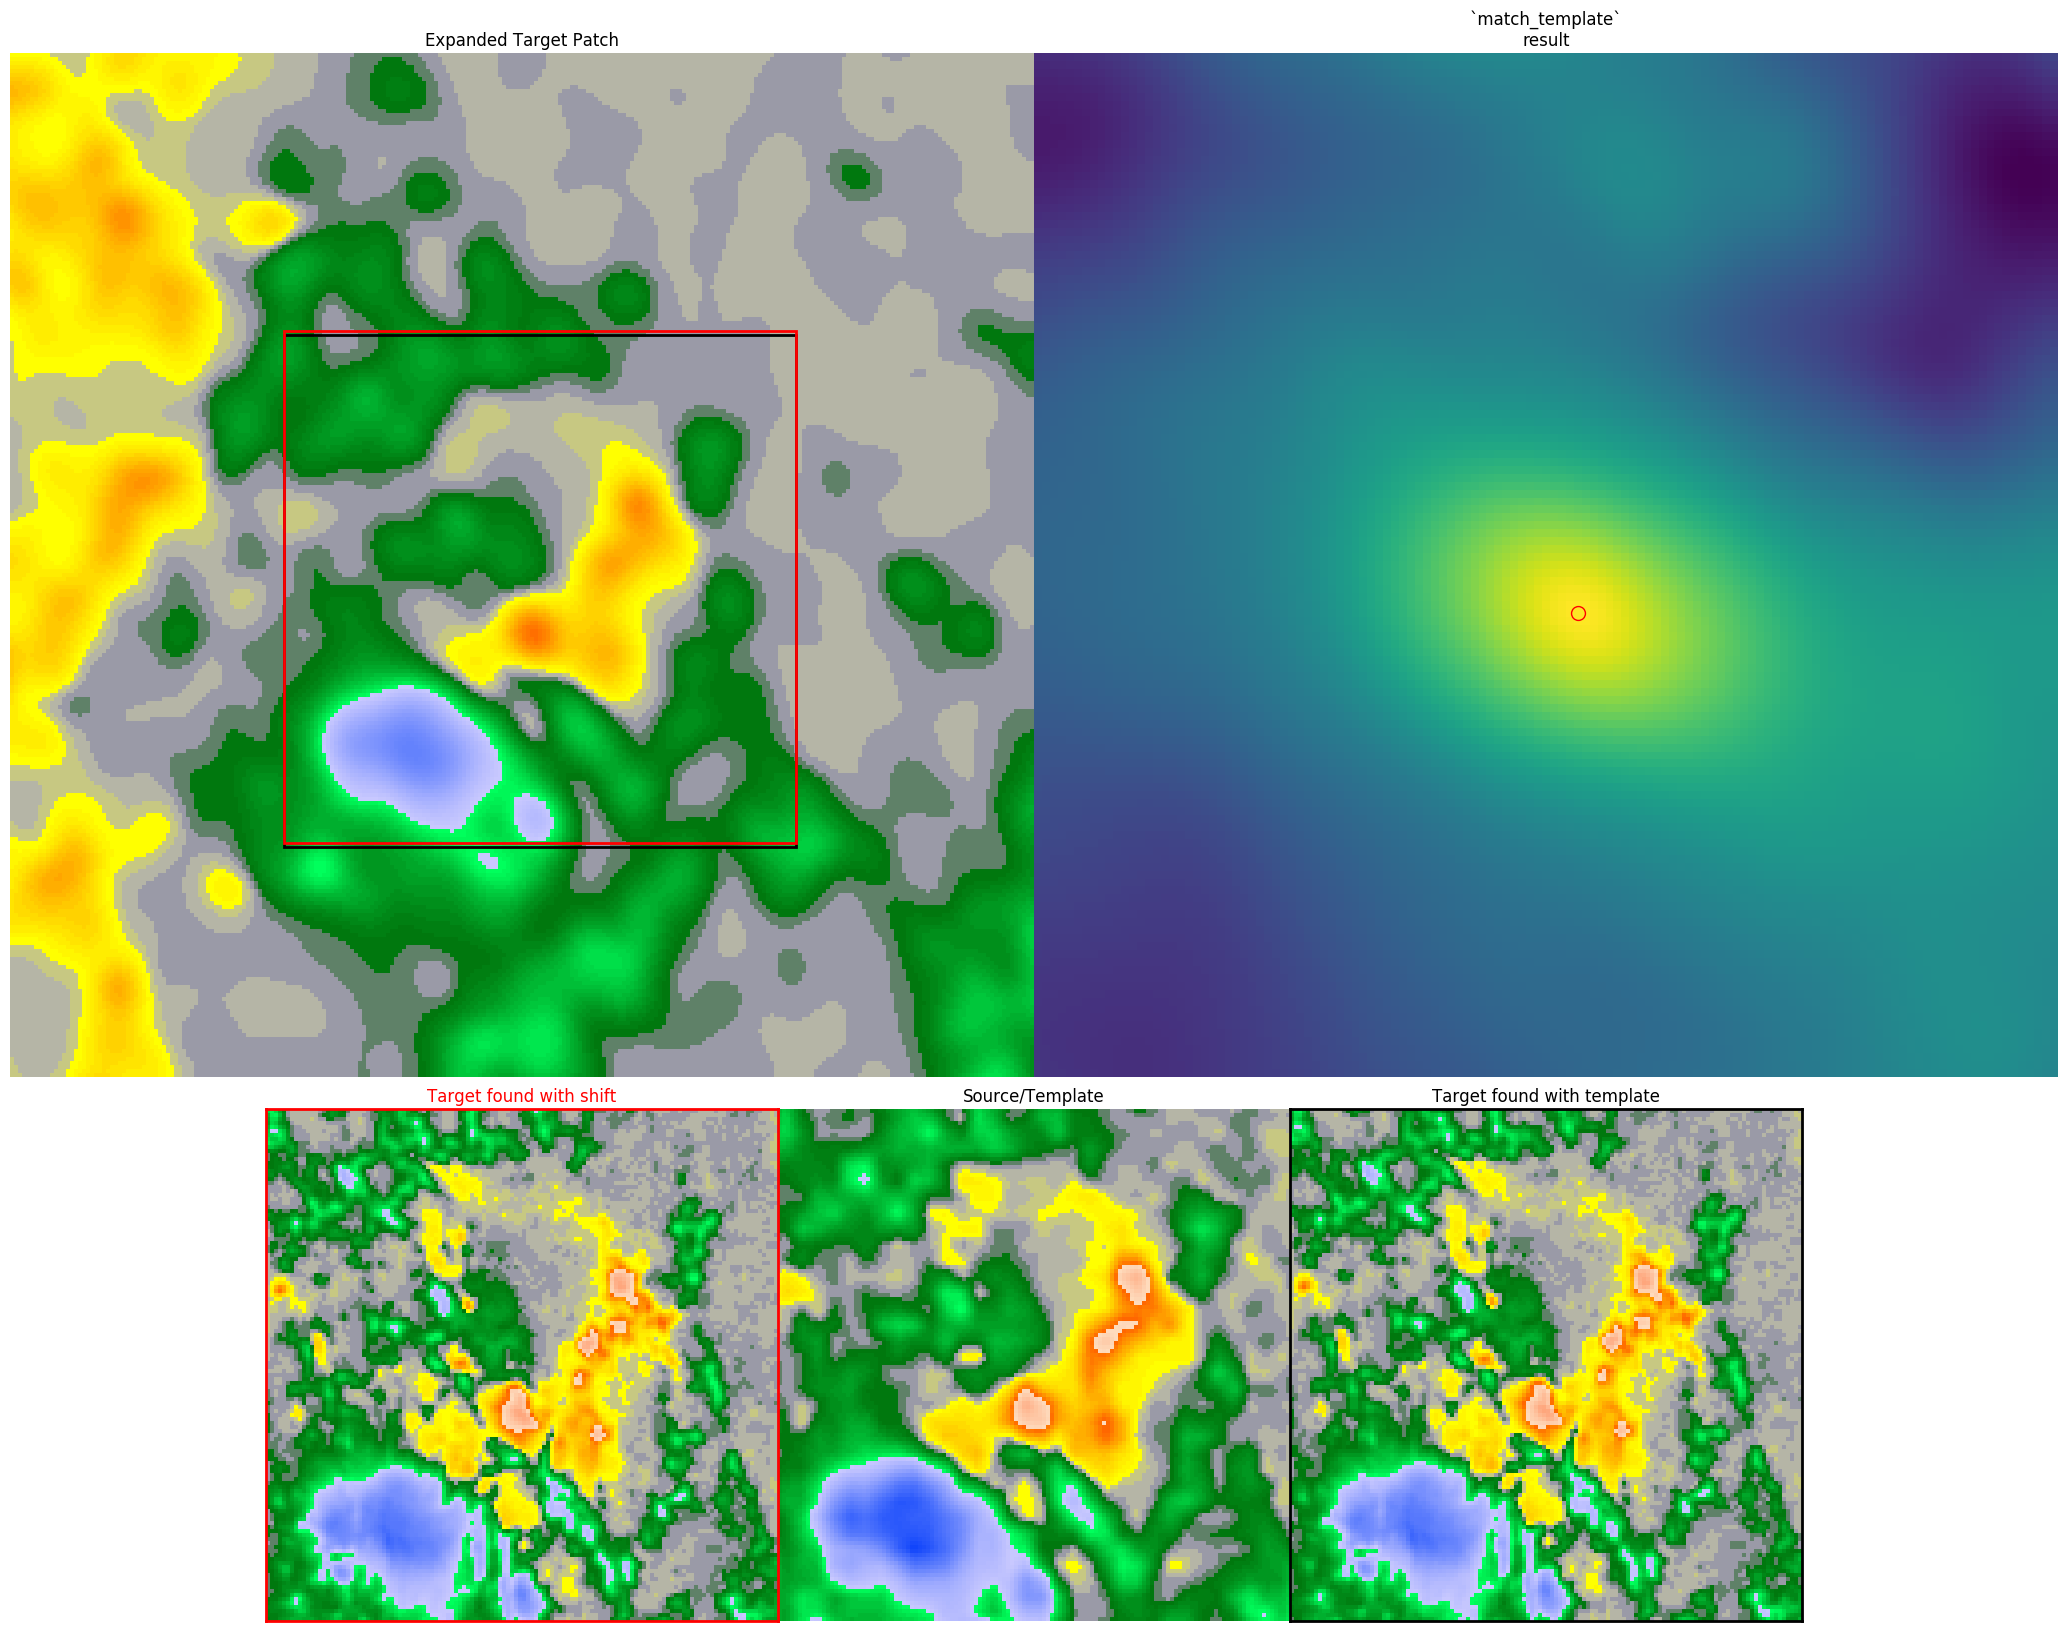

In [69]:
# inx = int(np.floor(np.random.rand()*target_patch.shape[0]))


# inx = 941
# Bad shifts
# inx = 716
# inx = 725
# inx = 756
# inx = 425

result = match_template(target_smooth_padded_patch[inx, 0, :, :], source_upsampled_patch[inx, 0, :, :])
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

shift = get_shift(source_upsampled_patch[inx, 0, :, :], target_smooth_patch[inx, 0, :, :])
print(-shift[1], -shift[0])
print(x + patchscale[0] - (patchscale[0]+buffer),y + patchscale[0] - (patchscale[0]+buffer))

xs = int((patchscale[0]+buffer)-patchscale[0]-shift[1])
ys = int((patchscale[0]+buffer)-patchscale[0]-shift[0])

# Size definitions
dpi = 100
pxx = 4*target_map_padded_patch.shape[3]  # Horizontal size of each extended panel
pxy = pxx   # Vertical size of each panel

pxx2 = 4*patchscale[0]  # Horizontal size of each panel
pxy2 = pxx2   # Vertical size of each panel


nph = 3     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = pxx/32  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each extended panel in relative units
ppxy   = pxy/fszv      # Vertical size of each extended panel in relative units

ppxx2   = pxx2/fszh      # Horizontal size of each panel in relative units
ppxy2   = pxy2/fszv      # Vertical size of each panel in relative units

ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units





## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

ax2 = fig.add_axes([ppadh, ppadv+ppxy2+ppadv2, ppxx, ppxy])

ax2.imshow(target_smooth_padded_patch[inx, 0, :, :], vmin=vmin, vmax=vmax, cmap=current_cmap)
ax2.set_axis_off()
ax2.set_title('Expanded Target Patch')
# highlight matched region
hcoin, wcoin = source_upsampled_patch[inx, 0, :, :].shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='k', facecolor='none', linewidth=2)
ax2.add_patch(rect)

rect = plt.Rectangle((xs, ys), wcoin, hcoin, edgecolor='red', facecolor='none', linewidth=2)
ax2.add_patch(rect)


ax3 = fig.add_axes([ppadh+ppxx, ppadv+ppxy2+ppadv2, ppxx, ppxy])

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)


offset = (2*ppxx - 3*ppxx2)/2

ax1 = fig.add_axes([ppadh+ppxx2+offset, ppadv, ppxx2, ppxy2])

ax1.imshow(source_upsampled_patch[inx, 0, :, :], vmin=vmin, vmax=vmax, cmap=current_cmap)
ax1.set_axis_off()
ax1.set_title('Source/Template')


ax4 = fig.add_axes([ppadh+2*ppxx2+offset, ppadv, ppxx2, ppxy2])

ax4.imshow(target_map_padded_patch[inx, 0, y:y+patchscale[0], x:x+patchscale[0]], vmin=vmin, vmax=vmax, cmap=current_cmap)
# ax4.set_axis_off()
ax4.set_title('Target found with template')
ax4.set_xticks([])
ax4.set_yticks([])
for side in ax4.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax4.spines[side].set_linewidth(2)


# ax.tick_params(axis='x', colors='red')


ax5 = fig.add_axes([ppadh+offset, ppadv, ppxx2, ppxy2])

ax5.imshow(target_map_padded_patch[inx, 0, ys:ys+patchscale[0], xs:xs+patchscale[0]], vmin=vmin, vmax=vmax, cmap=current_cmap)
ax5.set_title('Target found with shift',color='red')

for side in ax5.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax5.spines[side].set_linewidth(2)
    ax5.spines[side].set_color('red')

ax5.set_xticks([])
ax5.set_yticks([]);

# ax2.imshow(target_smooth_padded_patch[inx, 0, :, :], vmin=vmin, vmax=vmax, cmap=current_cmap)
# ax2.set_axis_off()
# ax2.set_title('Expanded Target Patch')
# # highlight matched region
# hcoin, wcoin = source_upsampled_patch[inx, 0, :, :].shape
# rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
# ax2.add_patch(rect)

# ax3.imshow(result)
# ax3.set_axis_off()
# ax3.set_title('`match_template`\nresult')
# # highlight matched region
# ax3.autoscale(False)
# ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

# ax4.imshow(target_map_padded_patch[inx, 0, y:y+patchscale[0], x:x+patchscale[0]], vmin=vmin, vmax=vmax, cmap=current_cmap)
# ax4.set_axis_off()
# ax4.set_title('target')

# plt.show()

4.0 5.0
4 6


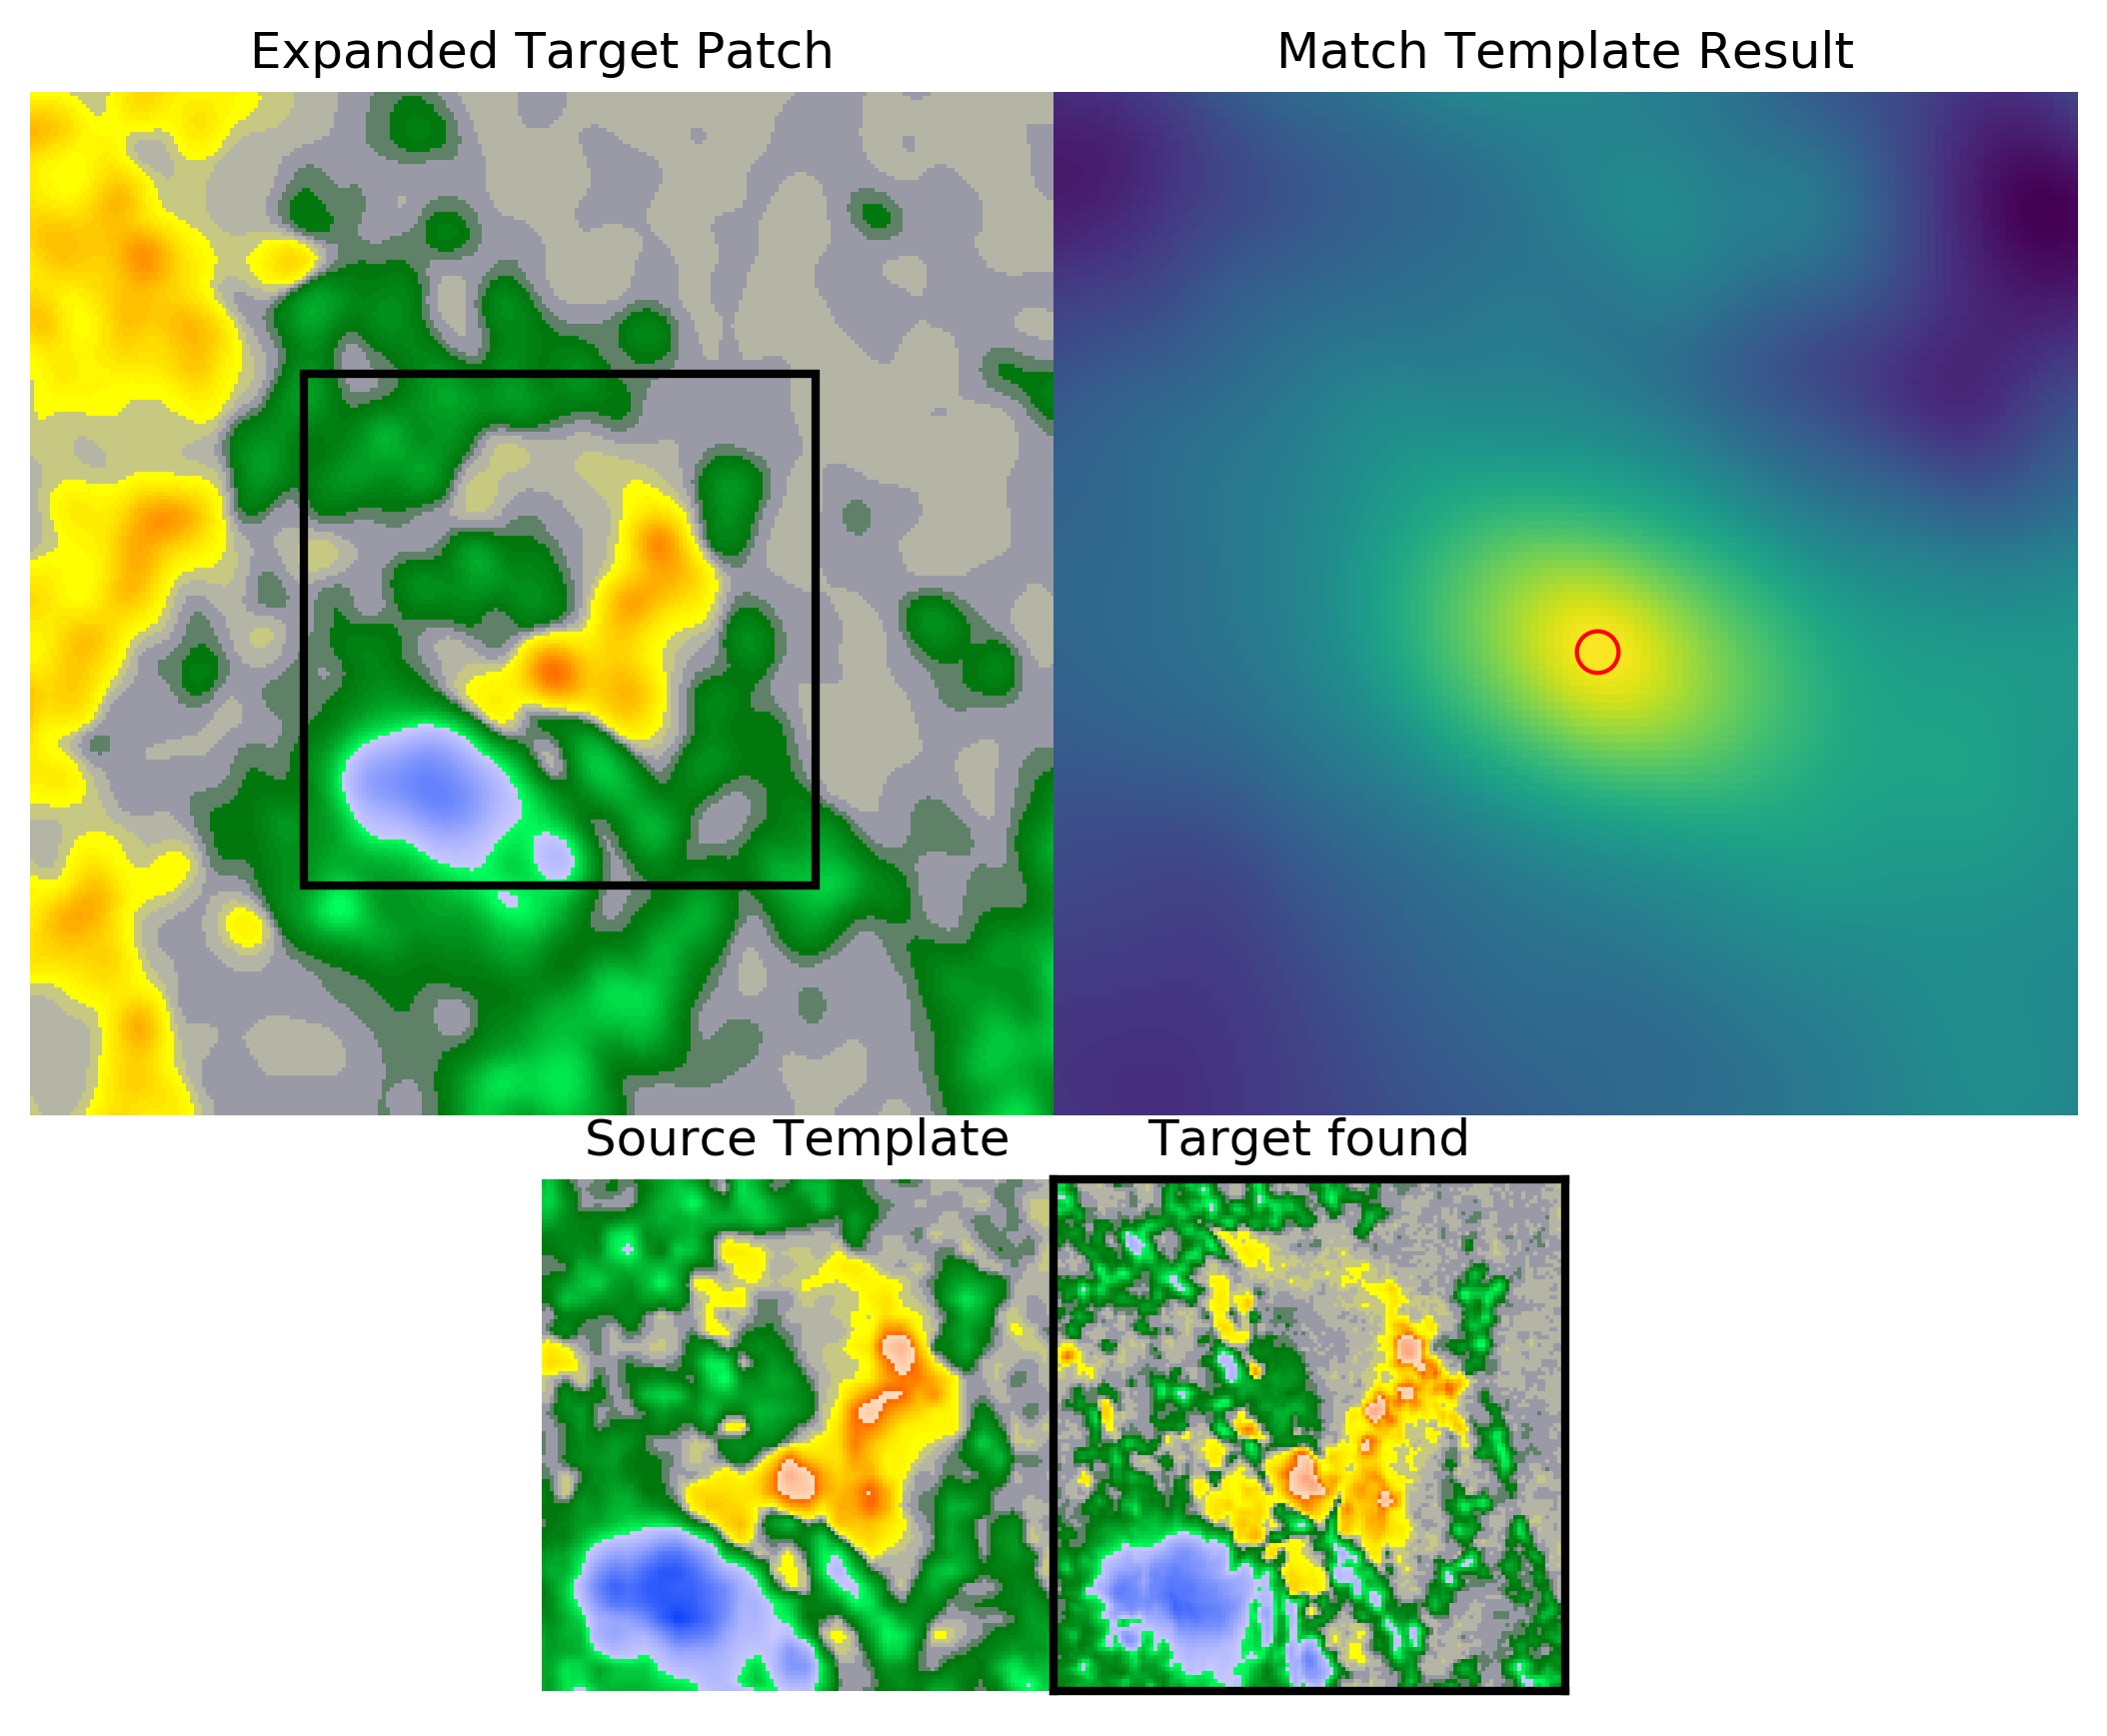

In [82]:
# inx = int(np.floor(np.random.rand()*target_patch.shape[0]))


# inx = 941
# Bad shifts
# inx = 716
# inx = 725
# inx = 756
# inx = 425

result = match_template(target_smooth_padded_patch[inx, 0, :, :], source_upsampled_patch[inx, 0, :, :])
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

shift = get_shift(source_upsampled_patch[inx, 0, :, :], target_smooth_patch[inx, 0, :, :])
print(-shift[1], -shift[0])
print(x + patchscale[0] - (patchscale[0]+buffer),y + patchscale[0] - (patchscale[0]+buffer))

xs = int((patchscale[0]+buffer)-patchscale[0]-shift[1])
ys = int((patchscale[0]+buffer)-patchscale[0]-shift[0])

# Size definitions
dpi = 300
pxx = 4*target_map_padded_patch.shape[3]  # Horizontal size of each extended panel
pxy = pxx   # Vertical size of each panel

pxx2 = 4*patchscale[0]  # Horizontal size of each panel
pxy2 = pxx2   # Vertical size of each panel


nph = 3     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = pxx/16  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each extended panel in relative units
ppxy   = pxy/fszv      # Vertical size of each extended panel in relative units

ppxx2   = pxx2/fszh      # Horizontal size of each panel in relative units
ppxy2   = pxy2/fszv      # Vertical size of each panel in relative units

ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units





## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

ax2 = fig.add_axes([ppadh, ppadv+ppxy2+ppadv2, ppxx, ppxy])

ax2.imshow(target_smooth_padded_patch[inx, 0, :, :], vmin=vmin, vmax=vmax, cmap=current_cmap)
ax2.set_axis_off()
ax2.set_title('Expanded Target Patch')
# highlight matched region
hcoin, wcoin = source_upsampled_patch[inx, 0, :, :].shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='k', facecolor='none', linewidth=2)
ax2.add_patch(rect)

# rect = plt.Rectangle((xs, ys), wcoin, hcoin, edgecolor='red', facecolor='none', linewidth=2)
# ax2.add_patch(rect)


ax3 = fig.add_axes([ppadh+ppxx, ppadv+ppxy2+ppadv2, ppxx, ppxy])

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('Match Template Result')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)


offset = (2*ppxx - 4*ppxx2)/2

ax1 = fig.add_axes([ppadh+ppxx2+offset, ppadv, ppxx2, ppxy2])

ax1.imshow(source_upsampled_patch[inx, 0, :, :], vmin=vmin, vmax=vmax, cmap=current_cmap)
ax1.set_axis_off()
ax1.set_title('Source Template')


ax4 = fig.add_axes([ppadh+2*ppxx2+offset, ppadv, ppxx2, ppxy2])

ax4.imshow(target_map_padded_patch[inx, 0, y:y+patchscale[0], x:x+patchscale[0]], vmin=vmin, vmax=vmax, cmap=current_cmap)
# ax4.set_axis_off()
ax4.set_title('Target found')
ax4.set_xticks([])
ax4.set_yticks([])
for side in ax4.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax4.spines[side].set_linewidth(2)


# ax.tick_params(axis='x', colors='red')


# ax5 = fig.add_axes([ppadh+offset, ppadv, ppxx2, ppxy2])

# ax5.imshow(target_map_padded_patch[inx, 0, ys:ys+patchscale[0], xs:xs+patchscale[0]], vmin=vmin, vmax=vmax, cmap=current_cmap)
# ax5.set_title('Target found with shift',color='red')

# for side in ax5.spines.keys():  # 'top', 'bottom', 'left', 'right'
#     ax5.spines[side].set_linewidth(2)
#     ax5.spines[side].set_color('red')

# ax5.set_xticks([])
# ax5.set_yticks([]);

# ax2.imshow(target_smooth_padded_patch[inx, 0, :, :], vmin=vmin, vmax=vmax, cmap=current_cmap)
# ax2.set_axis_off()
# ax2.set_title('Expanded Target Patch')
# # highlight matched region
# hcoin, wcoin = source_upsampled_patch[inx, 0, :, :].shape
# rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
# ax2.add_patch(rect)

# ax3.imshow(result)
# ax3.set_axis_off()
# ax3.set_title('`match_template`\nresult')
# # highlight matched region
# ax3.autoscale(False)
# ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

# ax4.imshow(target_map_padded_patch[inx, 0, y:y+patchscale[0], x:x+patchscale[0]], vmin=vmin, vmax=vmax, cmap=current_cmap)
# ax4.set_axis_off()
# ax4.set_title('target')

# plt.show()

fig.savefig('Template_match.png', bbox_inches='tight', dpi = dpi, pad_inches=0)